# New Jersey Institue of Technology
# CS 675: Machine Learning, Spring 2022

# Assignment 3

**Date due: 4/11/2022 11:59pm EDT**

Remark: I recommend to study the tutorials from the book "Python Data Science Handbook" on Colab: 
https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/Index.ipynb

In particular for this assigment we will use 

*   SVM: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb



In [1]:
#@title Imports and Helper and Visualization Functions

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    """Plot the decision boundary of DecisionTree"""
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    # plt.axis('equal')
    # ax.axis('off')    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    # ax.set(xlim=xlim, ylim=ylim)

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

---
## Data Loading and Preprocessing

We are using the Seaborn libary for data loading and preprocessing: https://seaborn.pydata.org/introduction.html

For this assigment we use the well known 'Iris Flower'-Dataset, which is well known in the ML community as a testing set (https://en.wikipedia.org/wiki/Iris_flower_data_set)



In [2]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# for this excersise we remove the  'setosa' species
iris = iris.loc[iris['species'] != 'setosa']

The next command `pairplot`. By default, this function will create a grid of Axes such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column. See: https://seaborn.pydata.org/generated/seaborn.pairplot.html

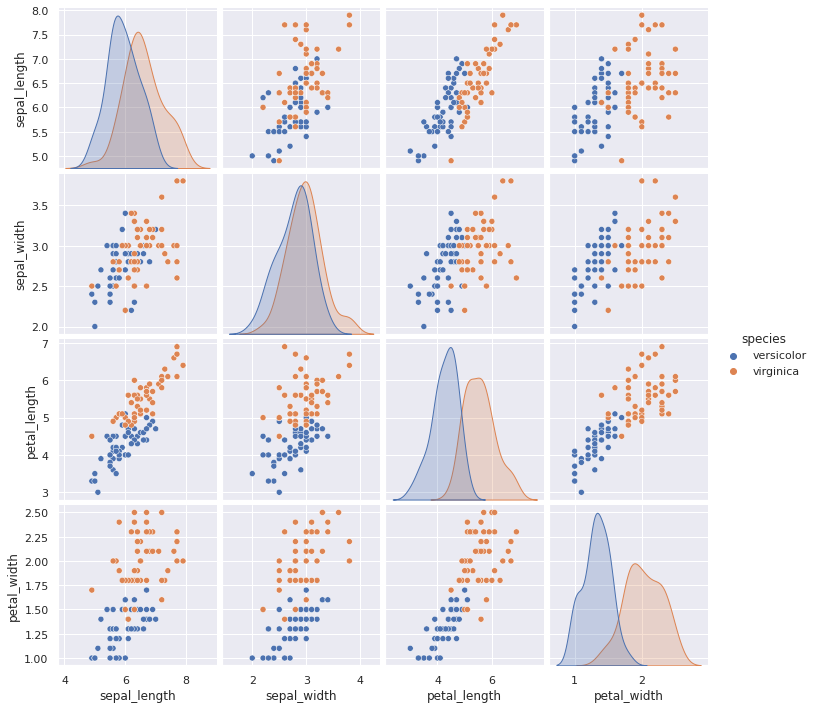

In [4]:
sns.pairplot(iris, hue='species', height=2.5);

For use in Scikit-Learn, we will extract the features matrix and target array from the seaborn dataframe and store them in numpy arrays

In [5]:
X_data = iris.drop('species', axis=1)
X_data = X_data.to_numpy()
X_data.shape


(100, 4)

In [6]:
# create a numeric arrays for the 3 species
y_data = iris.species.replace({'setosa': 2, 'versicolor': 1, 'virginica': 0}, inplace=False)
y_data = y_data.to_numpy()
y_data.shape


(100,)

In [7]:
## uncommend it if you want to try other data
# from sklearn.datasets import make_circles
# X_data, y_data = make_circles(100, factor=.8, noise=.3)

In [8]:
## We pre-process the data to map the features to 2D space. We will cover the method PCA for doing this later. 

from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_data)                     # 3. Fit to data. Notice y is not specified!
X_data_2D = model.transform(X_data)  

In the following we split the dataset into a training set and a test set and plot them. 

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_2D, y_data, random_state=1)

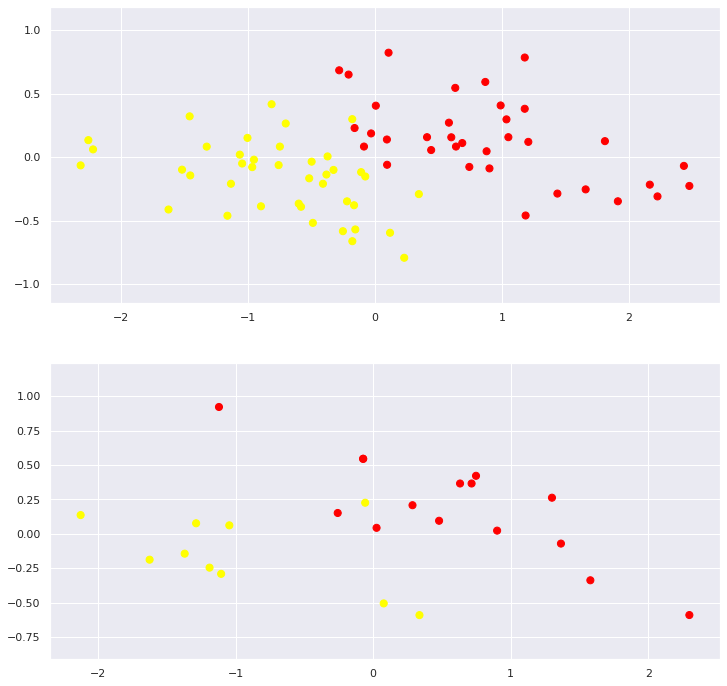

In [10]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plt.axis('equal')
plt.subplot(2,1,2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='autumn')
plt.axis('equal')
plt.show()

---
## [20 points] Task 1: Linear SVM 

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

For the pracrical implementation please refer to the nice tutorial on: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb

SVC classifier from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html



(1) **[6 points] In this subtask, implement the (soft-margin) linear SVM using the SVC classifer from sklearn. Note that you can leave C (the hyperparameter in soft-margin SVM as discussed in Page 52 of the slides) as the default value (C=1) in this subtask.**

In [11]:
###  Your code goes here
from sklearn.svm import SVC # "Support vector classifier"


# replace y_test in the line below with the prediction of your model
y_pred = y_test

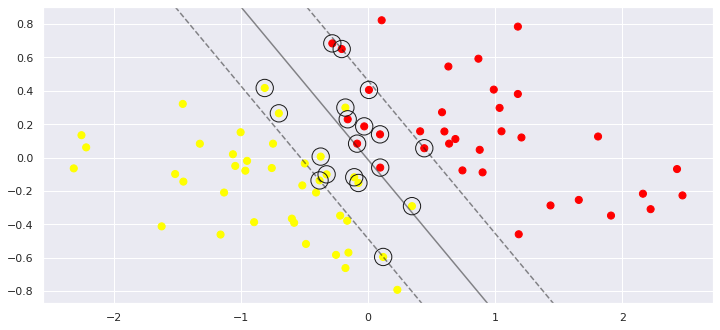

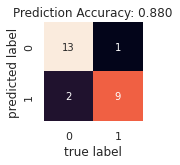

In [12]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_linear);
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

(2) **[10 points] Implement soft-margin SVM with different values of C. For example, you can try C=100, 1, 0.001.**



In [13]:
###  C=100
from sklearn.svm import SVC # "Support vector classifier"

# replace y_test in the line below with the prediction of your model
y_pred = y_test

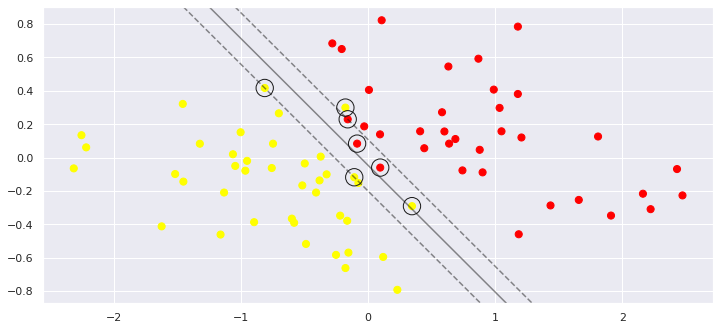

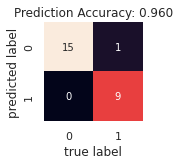

In [14]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_linear);
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

In [15]:
###  C=1
from sklearn.svm import SVC # "Support vector classifier"

# replace y_test in the line below with the prediction of your model
y_pred = y_test

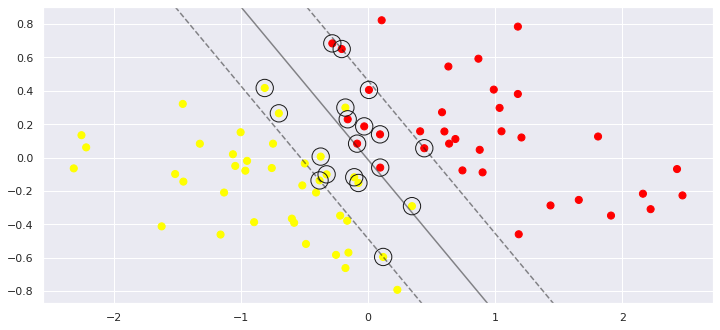

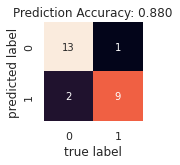

In [16]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_linear);
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

In [17]:
###  C=0.001
from sklearn.svm import SVC # "Support vector classifier"



# replace y_test in the line below with the prediction of your model
y_pred = y_test

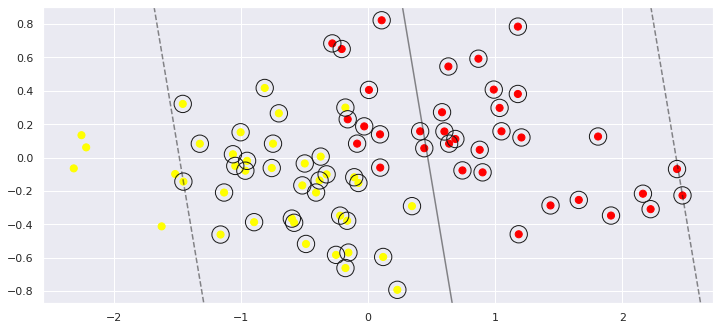

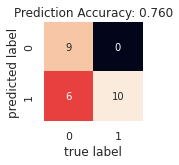

In [18]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_linear);
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

**(3)[4 points]  Discuss how different values of C affect the training results. For example, you can discuss how C affects the number of samples that violate the margin.**

Your observation goes here:  


---
## [10 points] Task 2: Kernel SVM 

For the pracrical implementation please refer to the nice tutorial on: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb

SVC classifier from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

**[10 points] Implement kernel SVM with different kernels. Specifically, try the Radial basis function (RBF) kernel and the polynomial kernel. For the polynomial kernel, please set the degree of the polynomial to 3. For both kernel, set C=100.**


In [19]:
### RBF Kernel
from sklearn.svm import SVC # "Support vector classifier"


# replace y_test in the line below with the prediction of your model
y_pred = y_test

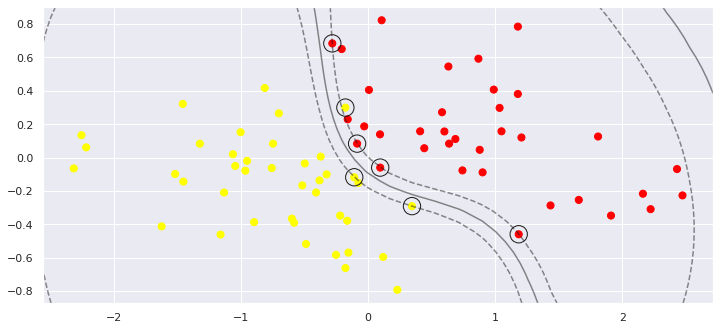

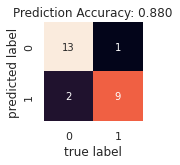

In [20]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_kernel)
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

In [21]:
###  Polynomial Kernel with degree 3
from sklearn.svm import SVC # "Support vector classifier"


# replace y_test in the line below with the prediction of your model
y_pred = y_test

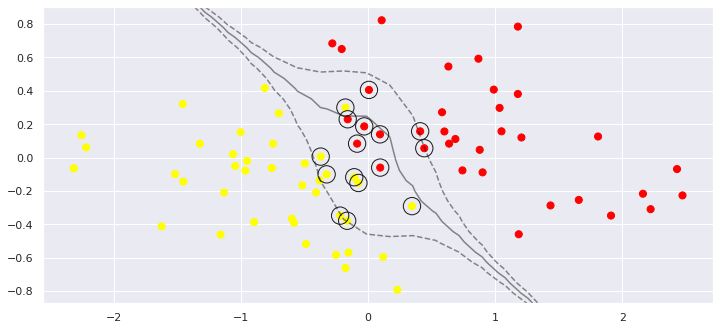

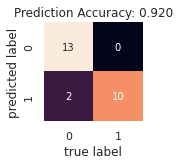

In [22]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_kernel)
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));